# Image Classification Modeling

**Summary**

In this notebook we will develop three different image classification Keras models to determine spectrogram images of minor and major chords.
We will start by creating a baseline convolutional neural network with two hidden layers. Our null baseline accuracy will be 58% because that is
the higher proportion of our class data. We will determine a models success by whether or not it exceeds our null baseline and baseline model.
We will use regression techniques to improve our baseline model, then use VGG16 and ResNet as transfer learning models.

In [38]:
# Imports to visualize data, and filter through directories
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import os

# Imports for CNN models
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array, normalize, set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Imports for VGG16 Model
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# Imports for InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [15]:
# Generating a random seed for this notebook to reduce any variation in out results.
#seed(1)
#set_random_seed(2)

In [39]:
# Gathering image data from a Google Drive containing two folders, one for each class (major, minor)
# Collecting data and converting it into a tf.data.Dataset object consisting of a train and test set.
img_train = image_dataset_from_directory('drive/MyDrive/scaled_data',
                                         validation_split = 0.25,
                                         image_size = (128, 128),
                                         subset = 'training',
                                         color_mode='rgb',
                                         seed = 42)

img_test = image_dataset_from_directory('drive/MyDrive/scaled_data',
                                         validation_split = 0.25,
                                         image_size = (128, 128),
                                         subset = 'validation',
                                         color_mode='rgb',
                                         seed = 42)

Found 2577 files belonging to 2 classes.
Using 1933 files for training.
Found 2577 files belonging to 2 classes.
Using 644 files for validation.


In [ ]:
# # Confirming no class imbalance for my 6 target outputs
# # If data is imbalanced, use class weights.

# base_directory = '/content/drive/MyDrive/GitHub Personal/speech-emotion-recognition/plots/spectograms'

# image_counts = {}

# # Iterate over subdirectories
# for subfolder in os.listdir(base_directory):
#     subfolder_path = os.path.join(base_directory, subfolder)
#     if os.path.isdir(subfolder_path):
#         # Count the number of files with .png extension in the subfolder
#         num_images = len([filename for filename in os.listdir(subfolder_path) if filename.endswith('.png')])
#         image_counts[subfolder] = num_images

# # Print counts for each subfolder
# for subfolder, count in image_counts.items():
#     print(f"Subfolder '{subfolder}': {count} images")

In [ ]:
# CNN Baseline Model

In [40]:
# Increasing number of filters in each Conv2D to capture more complex features
# and decreasing number of nodes in our Dense layers to focus our model on the most import features.


base_model = Sequential()

base_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', input_shape=(128, 128, 3)))
base_model.add(MaxPooling2D(pool_size = (2, 2)))

base_model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
base_model.add(MaxPooling2D(pool_size = (2, 2)))

base_model.add(Flatten())

base_model.add(Dense(16, activation='relu'))

base_model.add(Dense(1, activation='sigmoid'))

In [41]:
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [42]:
base = base_model.fit(img_train, validation_data=img_test, batch_size=64, epochs=10)

Epoch 1/10
61/61 [==============================] - 269s 4s/step - loss: 49.7704 - acc: 0.5717 - val_loss: 0.6911 - val_acc: 0.5792
Epoch 2/10
61/61 [==============================] - 77s 1s/step - loss: 0.6887 - acc: 0.5861 - val_loss: 0.6870 - val_acc: 0.5792
Epoch 3/10
61/61 [==============================] - 78s 1s/step - loss: 0.6847 - acc: 0.5861 - val_loss: 0.6839 - val_acc: 0.5792
Epoch 4/10
61/61 [==============================] - 78s 1s/step - loss: 0.6819 - acc: 0.5861 - val_loss: 0.6821 - val_acc: 0.5792
Epoch 5/10
61/61 [==============================] - 80s 1s/step - loss: 0.6802 - acc: 0.5861 - val_loss: 0.6812 - val_acc: 0.5792
Epoch 6/10
61/61 [==============================] - 79s 1s/step - loss: 0.6792 - acc: 0.5861 - val_loss: 0.6807 - val_acc: 0.5792
Epoch 7/10
61/61 [==============================] - 80s 1s/step - loss: 0.6787 - acc: 0.5861 - val_loss: 0.6806 - val_acc: 0.5792
Epoch 8/10
61/61 [==============================] - 80s 1s/step - loss: 0.6786 - acc: 0.

In [ ]:
# Baseline Model Performance

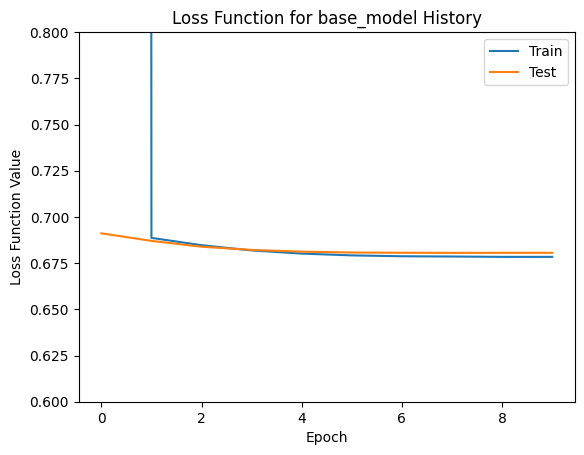

In [55]:
plt.plot(base.history['loss'], label = 'Train')
plt.plot(base.history['val_loss'], label = 'Test')
plt.title('Loss Function for base_model History')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.ylim(0.6, 0.8)
plt.legend();

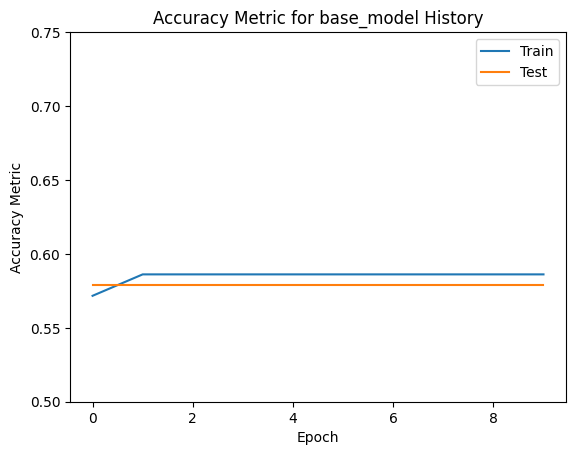

In [56]:
plt.plot(base.history['acc'], label = 'Train')
plt.plot(base.history['val_acc'], label = 'Test')
plt.title('Accuracy Metric for base_model History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Metric')
plt.ylim(0.5, 0.75)
plt.legend();

In [ ]:
# Conclusion

Our base model has not met our standards of succuess. Our validation accuracy (57.61%) is right below our null baseline of (58%).
We can see from the loss metric history of our model that quickly after the second epoch our model is stagnent and does little learning or development after.
We will attempt to migitagte this issue with all possible resources for model adaptations.

In [ ]:
# CNN model with Regression

Although our base model showed signs of over-fitness, it's poor accuracy is the most concerning. For this reason we will not add any regularization to
our next model because this will penalize our weights and will impeed on improving accuracy. We will add three more Conv2D and two more Dense hidden layers to allow the
model to find more complex relationships in the data.

In [47]:

# instantiates sequential baseline model
model_1 = Sequential()


# make a convolutional layer with 16 filters and MaxPool the results
model_1.add(Conv2D(8, kernel_size = (3, 3),
                   activation='relu',
                   input_shape=(128, 128, 3)))
model_1.add(MaxPooling2D(2))

# adds another conv2D layer
model_1.add(Conv2D(16, kernel_size = (3, 3),
                   activation='relu'))
model_1.add(MaxPooling2D(2))

# adds another conv2D layer
model_1.add(Conv2D(64, kernel_size = (3, 3),
                   activation='relu'))
model_1.add(MaxPooling2D(2))


# adds another conv2D layer
model_1.add(Conv2D(128, kernel_size = (3, 3),
                   activation='relu'))
model_1.add(MaxPooling2D(2))

# adds another conv2D layer
model_1.add(Conv2D(256, kernel_size = (3, 3),
                   activation='relu'))
model_1.add(MaxPooling2D(2))

# Finally, flatten the output and make a predictions.
model_1.add(Flatten())


model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(8, activation='relu'))

model_1.add(Dense(1, activation='sigmoid'))

In [48]:
model_1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc'] # try different metrics
)

In [50]:
model_res_1 = model_1.fit(
    img_train,
    validation_data=(img_test),
    batch_size=64,
    epochs=10
)

Epoch 1/10
61/61 [==============================] - 26s 388ms/step - loss: 1.9603 - acc: 0.5535 - val_loss: 0.6806 - val_acc: 0.5792
Epoch 2/10
61/61 [==============================] - 26s 408ms/step - loss: 0.6798 - acc: 0.5861 - val_loss: 0.6821 - val_acc: 0.5792
Epoch 3/10
61/61 [==============================] - 24s 371ms/step - loss: 0.6843 - acc: 0.5861 - val_loss: 0.6801 - val_acc: 0.5792
Epoch 4/10
61/61 [==============================] - 23s 352ms/step - loss: 0.6812 - acc: 0.5861 - val_loss: 0.6805 - val_acc: 0.5792
Epoch 5/10
61/61 [==============================] - 24s 372ms/step - loss: 0.6794 - acc: 0.5861 - val_loss: 0.6823 - val_acc: 0.5792
Epoch 6/10
61/61 [==============================] - 22s 350ms/step - loss: 0.6798 - acc: 0.5861 - val_loss: 0.6912 - val_acc: 0.5792
Epoch 7/10
61/61 [==============================] - 24s 371ms/step - loss: 0.6822 - acc: 0.5861 - val_loss: 0.6790 - val_acc: 0.5792
Epoch 8/10
61/61 [==============================] - 24s 370ms/step - 

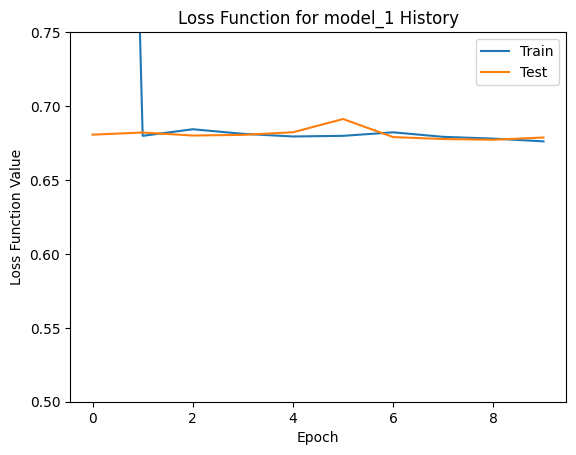

In [52]:
plt.plot(model_res_1.history['loss'], label = 'Train')
plt.plot(model_res_1.history['val_loss'], label = 'Test')
plt.title('Loss Function for model_1 History')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.ylim(0.5, 0.75)
plt.legend();

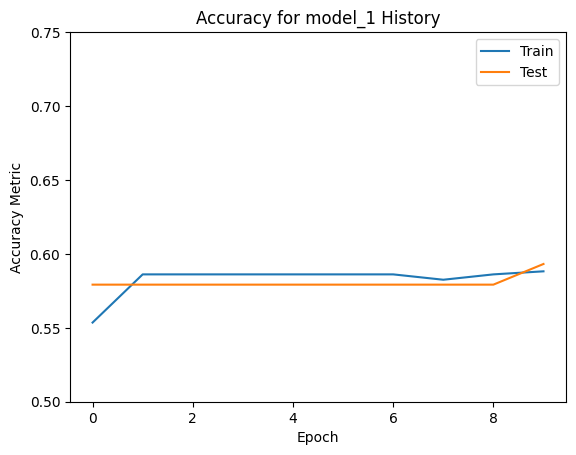

In [54]:
plt.plot(model_res_1.history['acc'], label = 'Train')
plt.plot(model_res_1.history['val_acc'], label = 'Test')
plt.title('Accuracy for model_1 History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Metric')
plt.ylim(0.5, 0.75)
plt.legend();

In [4]:
# VGG16 Model

In [5]:
train_path = 'drive/MyDrive/spectrograms/train'
test_path = 'drive/MyDrive/spectrograms/test'

In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
vgg16_model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.1),
    layers.Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Adjust the number of output classes as needed
])


In [10]:
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')


Found 2577 images belonging to 2 classes.


In [12]:
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 859 images belonging to 2 classes.


In [13]:
vgg16_model.fit(
    train_generator, validation_data = test_generator,
    epochs=10, verbose=1)


Epoch 1/10
81/81 [==============================] - 1401s 17s/step - loss: 1.4260 - accuracy: 0.5603 - val_loss: 0.6865 - val_accuracy: 0.5856
Epoch 2/10
81/81 [==============================] - 1393s 17s/step - loss: 0.6838 - accuracy: 0.5840 - val_loss: 0.6826 - val_accuracy: 0.5832
Epoch 3/10
81/81 [==============================] - 1392s 17s/step - loss: 0.6875 - accuracy: 0.5836 - val_loss: 0.6792 - val_accuracy: 0.5844
Epoch 4/10
81/81 [==============================] - 1393s 17s/step - loss: 0.6797 - accuracy: 0.5840 - val_loss: 0.6791 - val_accuracy: 0.5844
Epoch 5/10
81/81 [==============================] - 1396s 17s/step - loss: 0.6801 - accuracy: 0.5840 - val_loss: 0.6789 - val_accuracy: 0.5844
Epoch 6/10
81/81 [==============================] - 1395s 17s/step - loss: 0.6789 - accuracy: 0.5844 - val_loss: 0.6788 - val_accuracy: 0.5844
Epoch 7/10
81/81 [==============================] - 1430s 18s/step - loss: 0.6789 - accuracy: 0.5844 - val_loss: 0.6787 - val_accuracy: 0.5844

In [ ]:
# https://builtin.com/machine-learning/vgg16
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [ ]:
# https://keras.io/api/applications/#usage-examples-for-image-classification-models


# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit(...)